In [1]:
import pandas as pd
# import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import analysis_util
import tqdm
from scipy.stats import pearsonr, spearmanr
import numpy as np
import plotly.express as px
import datetime
import nltk 
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [2]:
subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird','DTU']
period = '2015-01-01-2022-01-01'

df_post_dict = {}
df_comment_dict = {}
df_all_nodes_dict = {}
G_dict = {}
G_di_dict = {}
df_authors_dict = {}
df_comment_post_dict = {}


for subreddit in subreddits:
    print(subreddit)
    path_post='../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_posts.csv"
    path_comment = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_comments.csv"
    path_awards = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards.csv"
    path_awards_comments = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards_comments.csv"
    
    df_comments=analysis_util.read_comments(path_comment,path_awards_comments)
    df_post=analysis_util.read_posts(path_post,path_awards)
    df_all_nodes=analysis_util.get_all_nodes(df_post,df_comments)    
    G_di = analysis_util.get_DiGraph(df_post,df_comments,df_all_nodes)
    G=analysis_util.get_graph(df_post,df_comments,df_all_nodes)
    G_big=analysis_util.get_biggest_component(G)    
    df_comment_post = analysis_util.get_comment_post_date(df_comments,df_post)
    df_authors = analysis_util.get_authors(G,df_all_nodes,df_comments,df_post,df_comment_post)
    
    df_comment_post_dict[subreddit] = df_comment_post
    df_comment_dict[subreddit] = df_comments
    df_post_dict[subreddit] = df_post
    df_all_nodes_dict[subreddit] = df_all_nodes
    G_dict[subreddit] = G_big
    df_authors_dict[subreddit] = df_authors
    G_di_dict[subreddit] = G_di
    print('')

FourSentenceStories
Removed 0.008264462809917328 of the rows

Trump666
Removed 0.023008849557522026 of the rows

GraphTheory
Removed 0.046391752577319645 of the rows

jazznoir
Removed 0.056192660550458795 of the rows

indoorbouldering
Removed 0.013580246913580174 of the rows

kiwi_bird
Removed 0.01412429378531077 of the rows

DTU
Removed 0.02263374485596703 of the rows



In [3]:
# conver sum_awards to int
for subreddit in subreddits:
    df_authors_dict[subreddit]['sum_awards'] = df_authors_dict[subreddit]['sum_awards'].astype(int)
    # df_authors_dict[subreddit]['award'] = df_authors_dict[subreddit][df_authors_dict[subreddit]['sum_awards'] < 1]['sum_awards'].astype(boolean)
    # add column for award as boolean
    df_authors_dict[subreddit]['award'] = df_authors_dict[subreddit]['sum_awards'] > 0

In [4]:
# conver sum_awards to int
for subreddit in subreddits:
    df_comment_dict[subreddit]['n_awards'] = df_comment_dict[subreddit]['n_awards'].astype(int)
    df_comment_dict[subreddit]['award'] = df_comment_dict[subreddit]['n_awards'] > 0

for subreddit in subreddits:
    # nan to zero
    df_post_dict[subreddit]['n_awards'] = df_post_dict[subreddit]['n_awards'].fillna(0)
    df_post_dict[subreddit]['n_awards'] = df_post_dict[subreddit]['n_awards'].astype(int)
    df_post_dict[subreddit]['award'] = df_post_dict[subreddit]['n_awards'] > 0

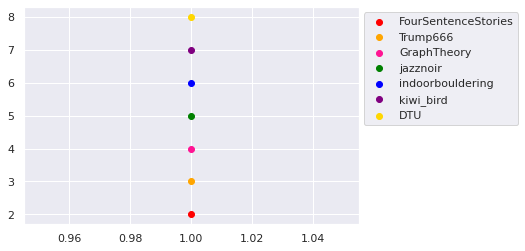

In [5]:
# a color for each subreddit in a dictionary
color_dict = {'FourSentenceStories':'#FF0000','Trump666':'#FFA500','GraphTheory':'#FF1493','jazznoir':'#008000','indoorbouldering':'#0000FF','kiwi_bird':'#800080','DTU':'#FFD700'}

# plot each color
i = 1
for subreddit in subreddits:
    i = 1 + i
    plt.scatter([1], [i], c=color_dict[subreddit], label=subreddit)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# # change grahtheory color to dark baby red
color_dict['GraphTheory'] = '#FF1493'

# Distributions

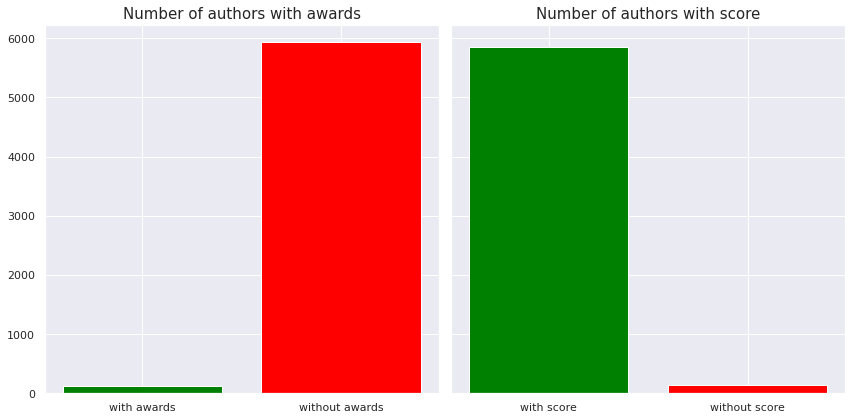

In [6]:
# # # # count number of authors with awards
A = 0
na = 0
for subreddit in subreddits:
#     df_authors_dict[subreddit]['sum_awards']=df_authors_dict[subreddit].sum_awards.astype(int)
    A=df_authors_dict[subreddit][df_authors_dict[subreddit]['sum_awards'] > 0]['sum_awards'].count()  + A
    na=df_authors_dict[subreddit][df_authors_dict[subreddit]['sum_awards'] < 1]['sum_awards'].count() + na

s = 0
ns = 0
for subreddit in subreddits:
#     df_authors_dict[subreddit]['sum_awards']=df_authors_dict[subreddit].sum_awards.astype(int)
    s=df_authors_dict[subreddit][df_authors_dict[subreddit]['sum_score'] > 0]['sum_score'].count()  + s
    ns=df_authors_dict[subreddit][df_authors_dict[subreddit]['sum_score'] == 0]['sum_score'].count() + ns



# plot subfigure
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].bar(['with awards','without awards'],[A,na],color=['#008000','#FF0000'])
axs[0].set_title('Number of authors with awards',fontsize=15)
axs[1].bar(['with score','without score'],[s,ns],color=['#008000','#FF0000'])
axs[1].set_title('Number of authors with score',fontsize=15)

plt.tight_layout()
plt.show()


# Correlations

/home/pelle/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


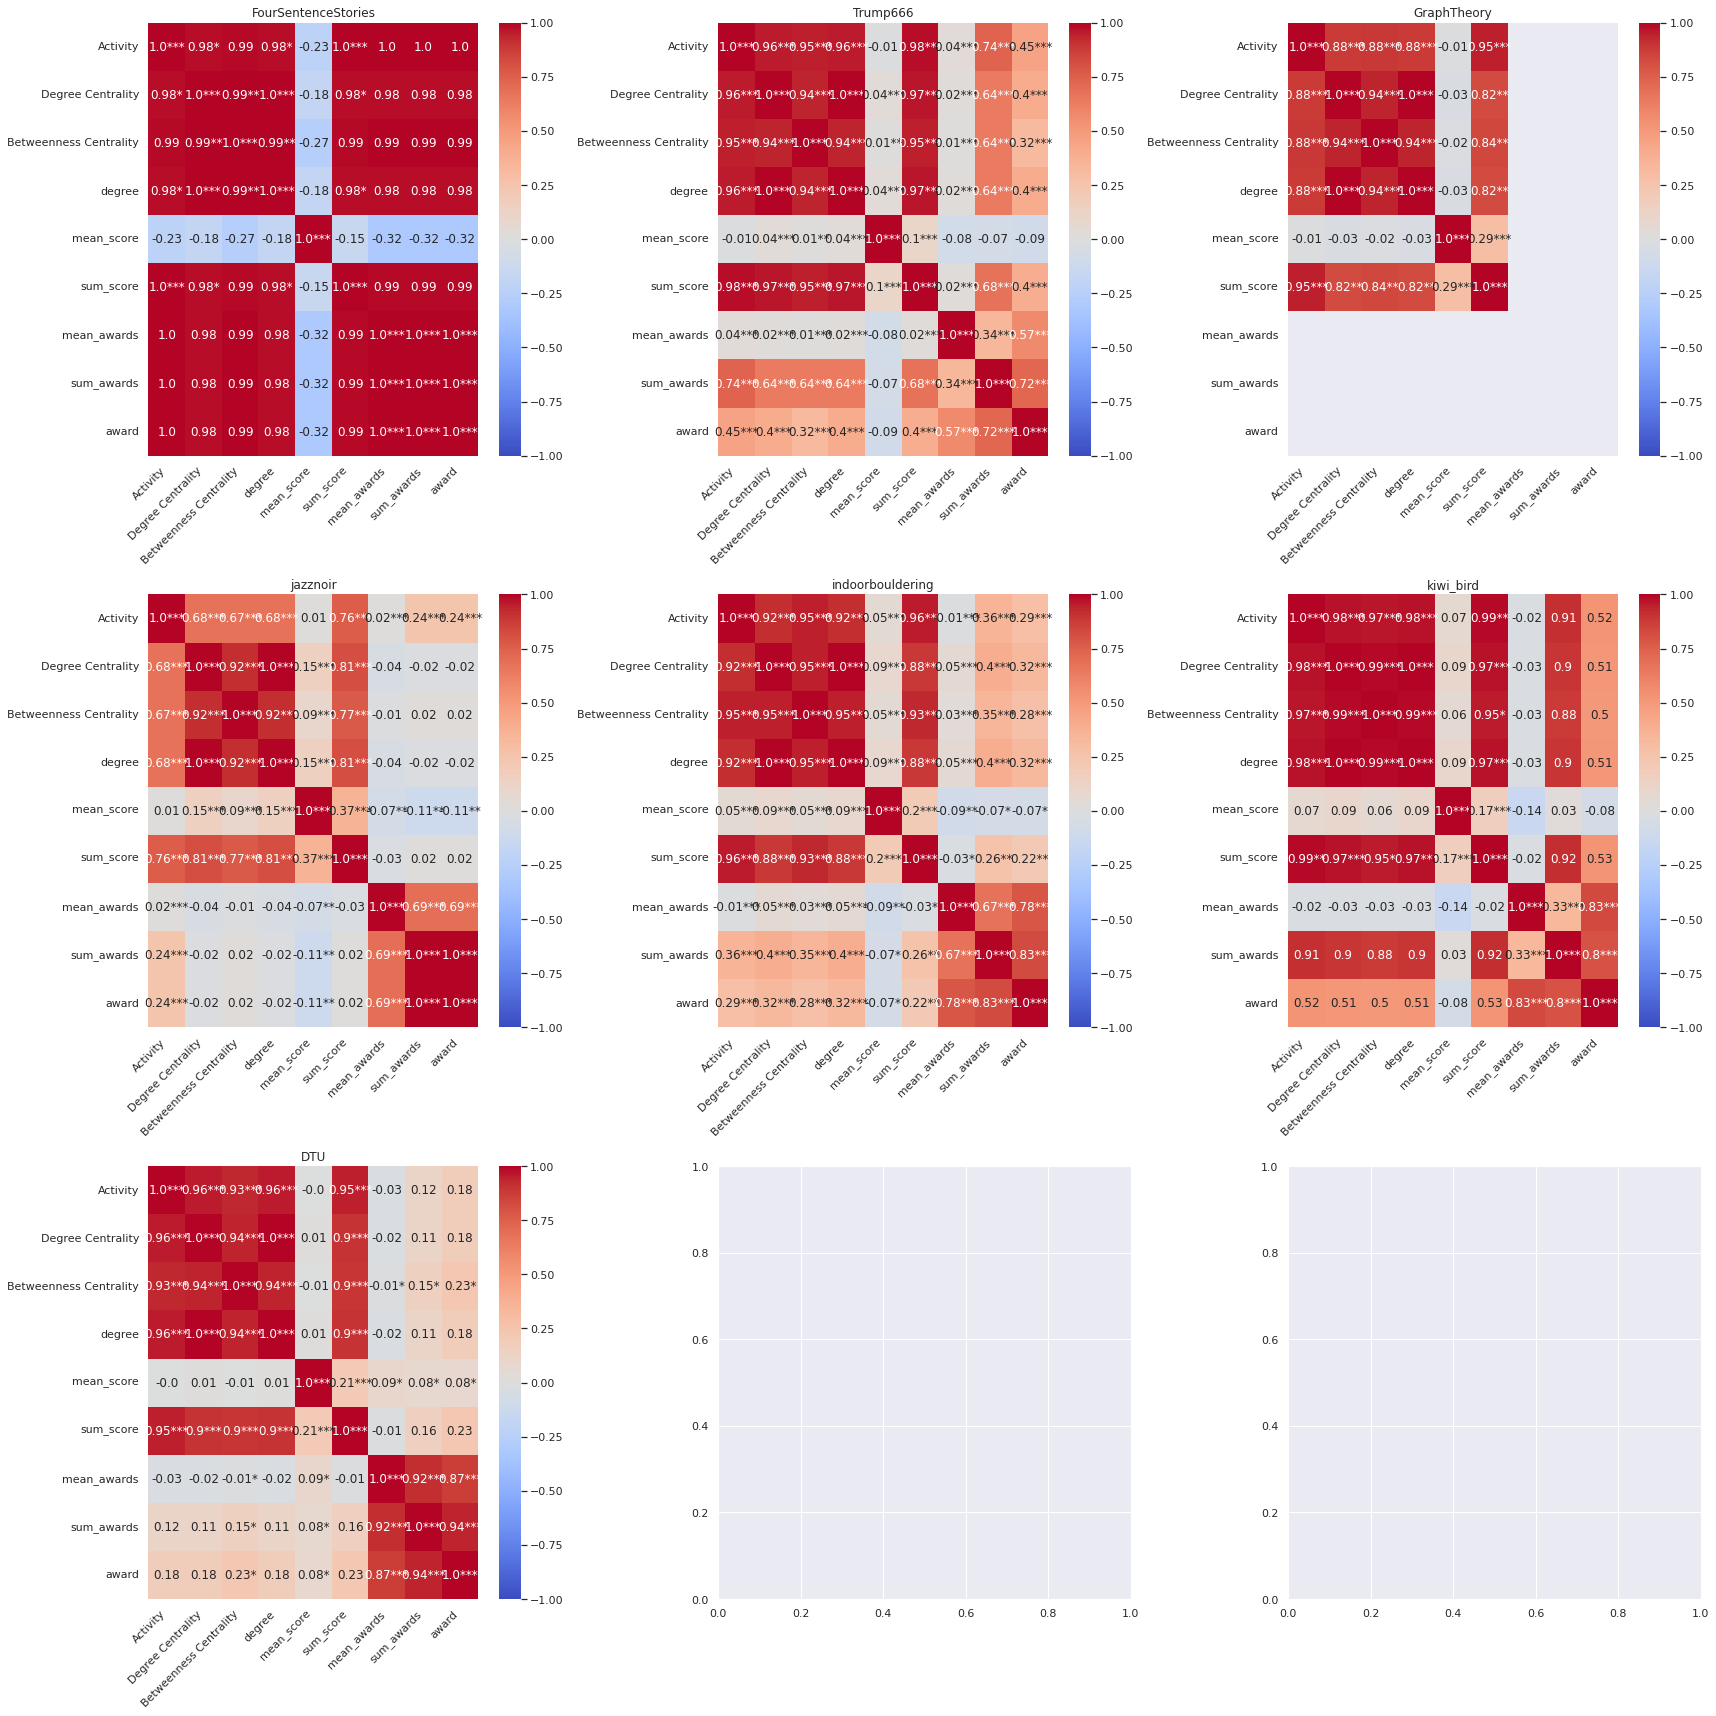

In [8]:
# only for Activity higher than 5
fig, axs = plt.subplots(3, 3, figsize=(8*3,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    rho = df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>3].corr()
    pval = df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>3].corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    
    # print(pval)

    sns.heatmap(data=rho, annot=(np.array(rho.round(2).astype(str) + p)),fmt = '',vmin=-1,vmax=1,cmap='coolwarm',ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, horizontalalignment='right')
    axs[i].set_title(subreddit)

plt.tight_layout()
plt.show()

In [9]:
# join df_authors and make corralation matrix
df_authors = pd.concat(df_authors_dict)
df_authors = df_authors.reset_index()
df_authors = df_authors.rename(columns={'level_0':'subreddit','level_1':'author'})

for subreddit in tqdm.tqdm(subreddits):
    df_authors.loc[df_authors['subreddit']==subreddit,'graph_size'] = G_dict[subreddit].number_of_nodes()
    df_authors.loc[df_authors['subreddit']==subreddit,'graph_edges'] = G_dict[subreddit].number_of_edges()
    df_authors.loc[df_authors['subreddit']==subreddit,'graph_average_clustering'] = nx.average_clustering(G_dict[subreddit])
    df_authors.loc[df_authors['subreddit']==subreddit,'graph_average_shortest_path_length'] = nx.average_shortest_path_length(G_dict[subreddit])

100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


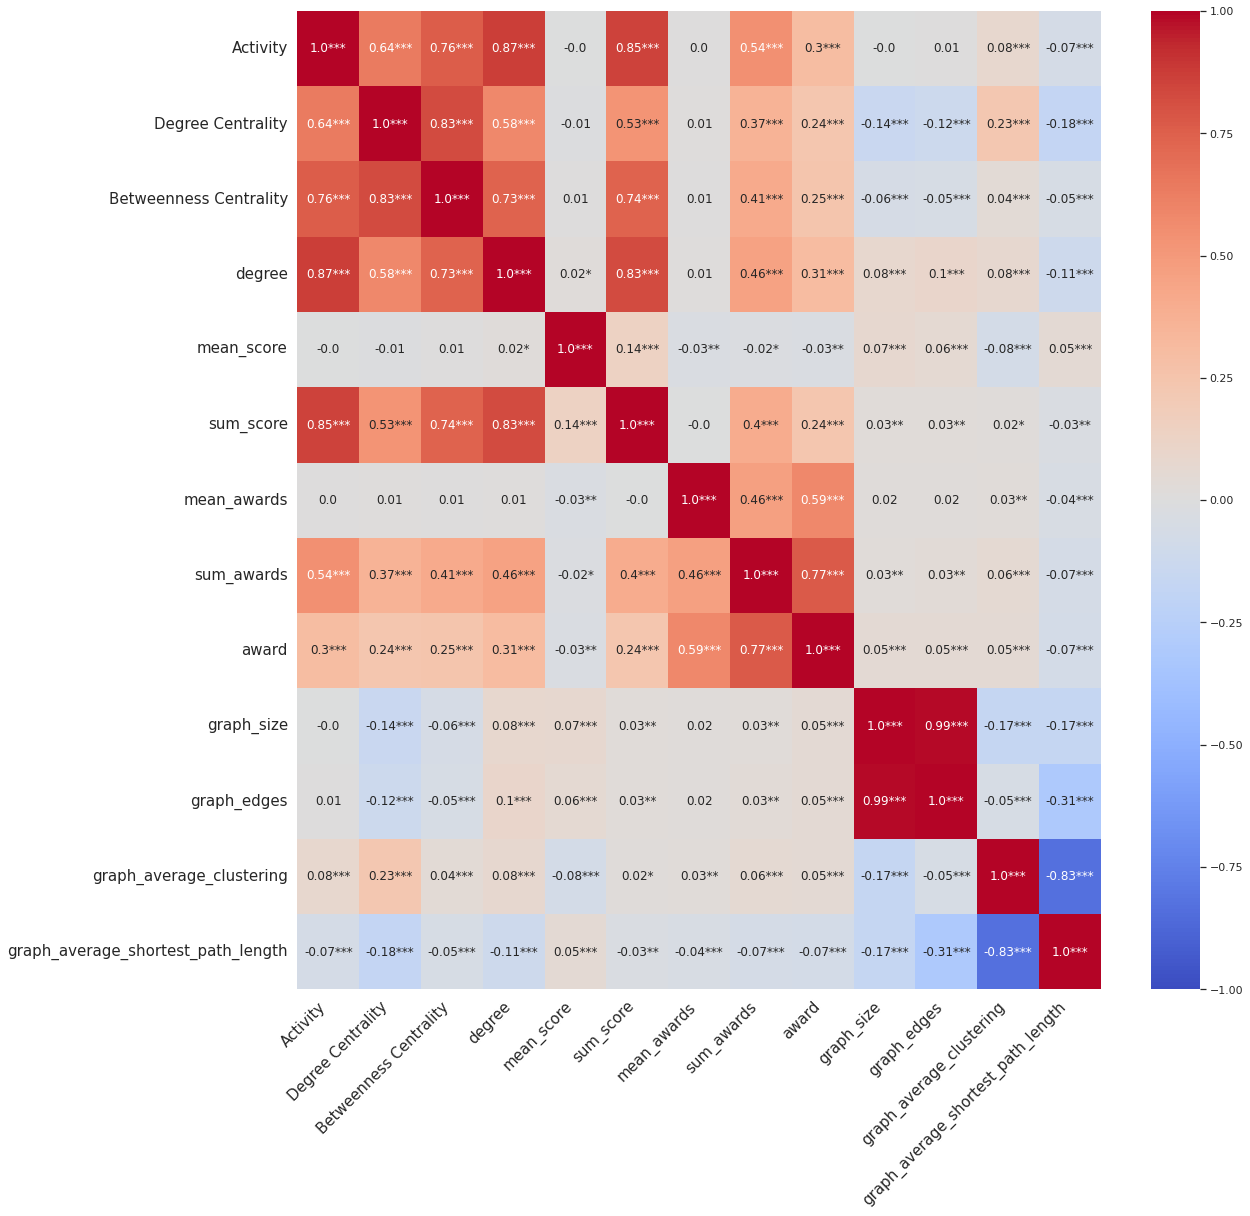

In [10]:
rho = df_authors.corr()
pval = df_authors.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))

fig, ax = plt.subplots(figsize=(18,18))

sns.heatmap(data=rho, annot=(np.array(rho.round(2).astype(str) + p)),fmt = '',vmin=-1,vmax=1,cmap='coolwarm')
# 

# rotate xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)

plt.savefig('correlation_matrix.png',dpi=300)
plt.show()

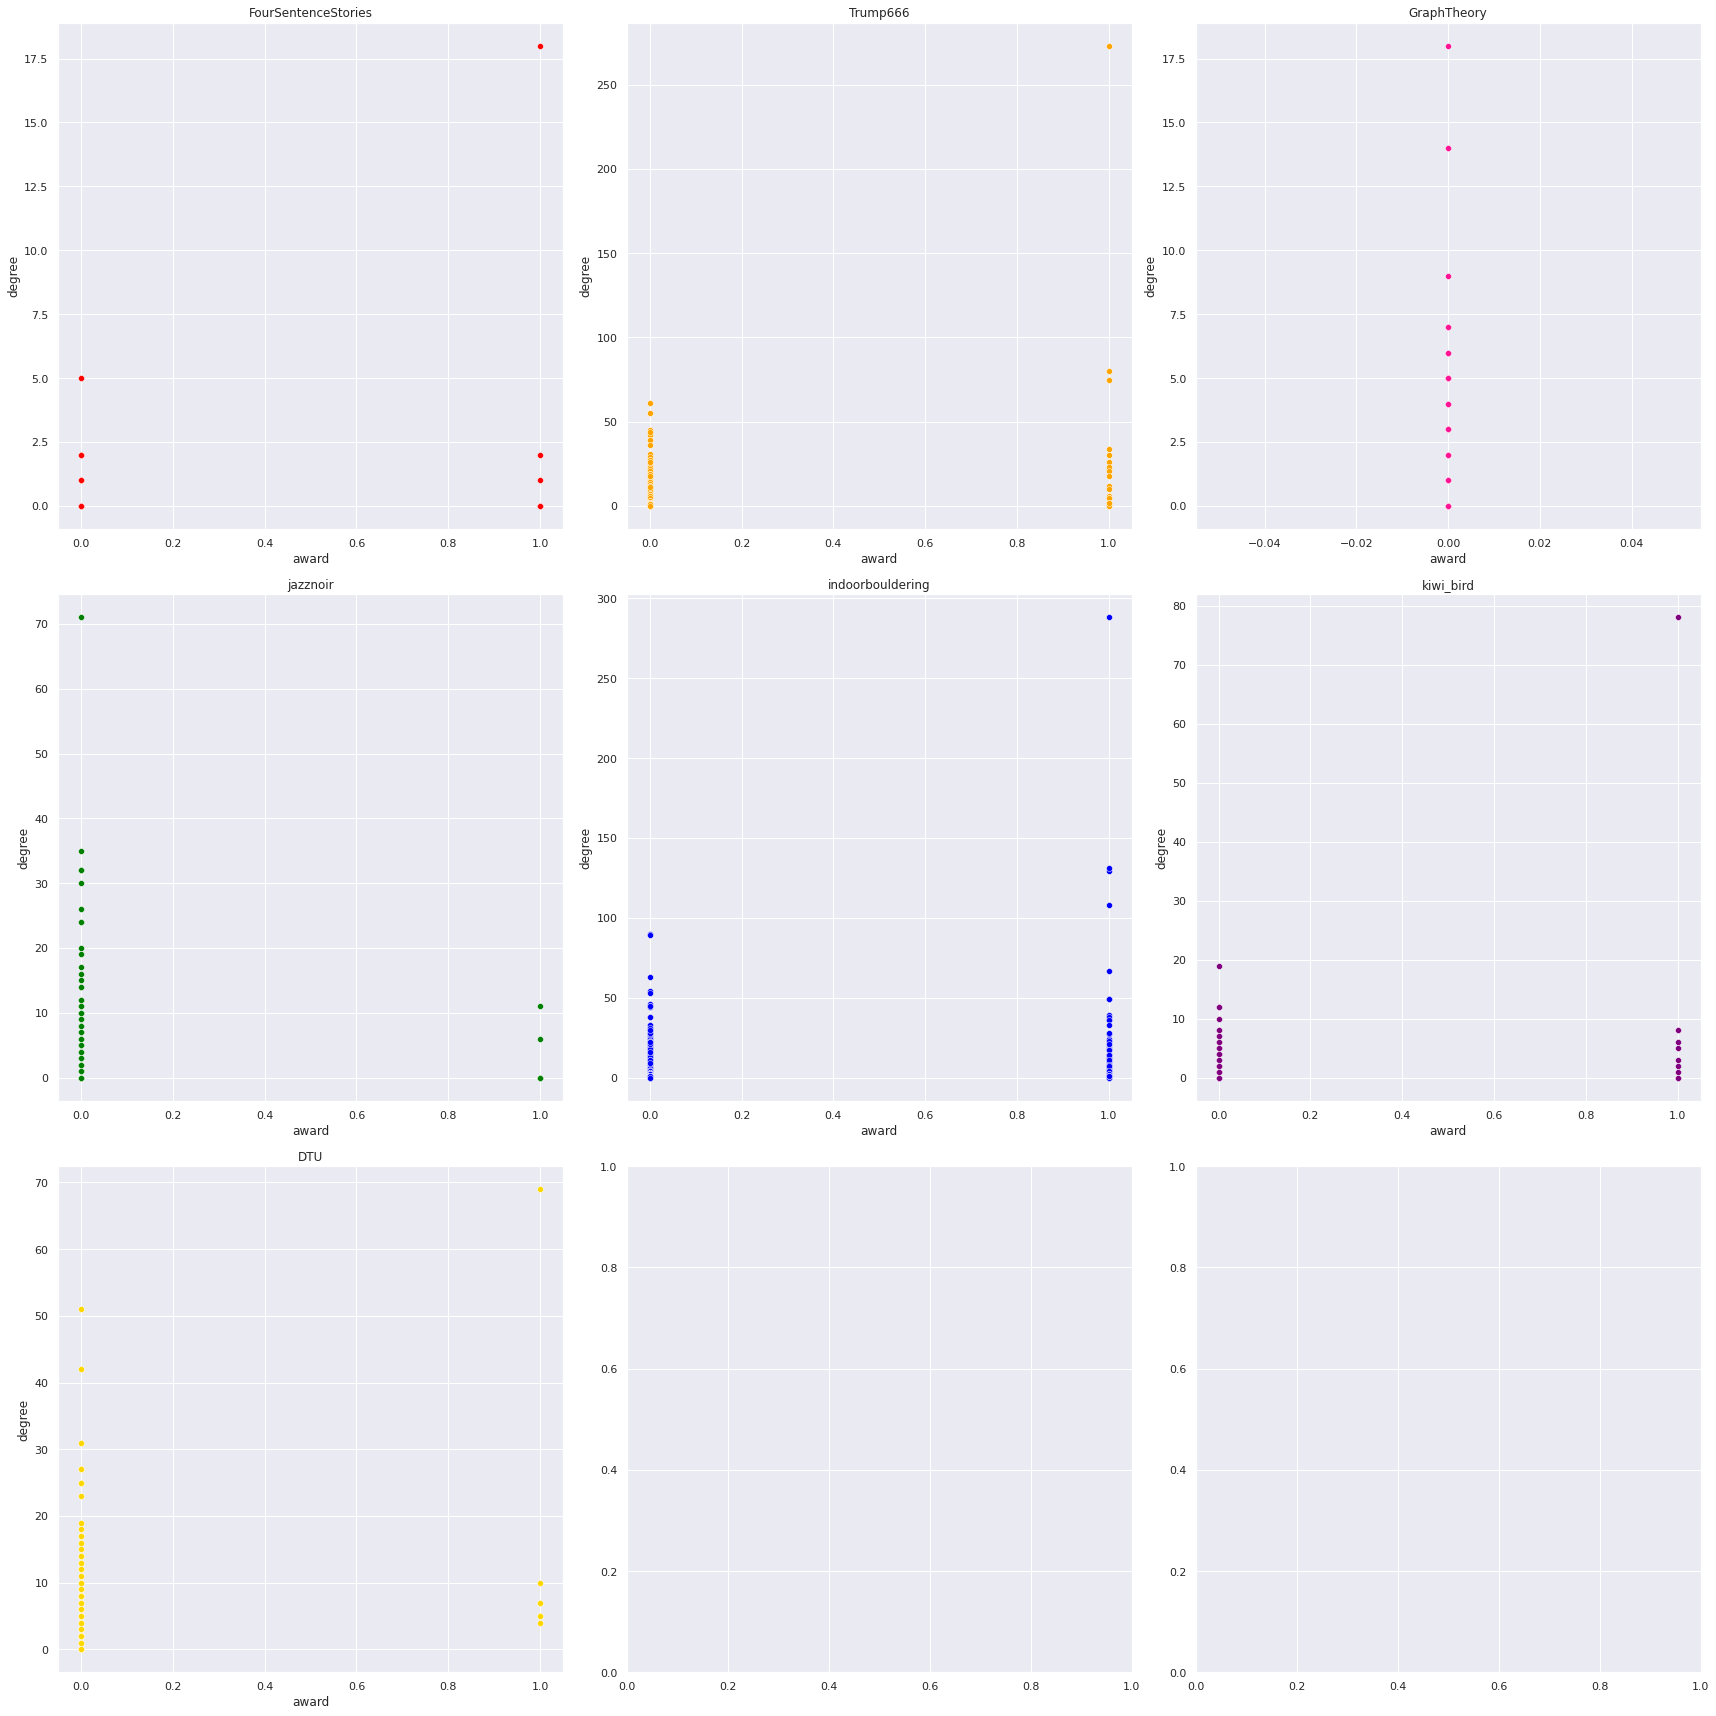

In [11]:
# df_authors_dict['FourSentenceStories'].head()

# plot mean score for each subreddit
fig, axs = plt.subplots(3, 3, figsize=(8*3,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    sns.scatterplot(x=df_authors_dict[subreddit]['award'],y=df_authors_dict[subreddit]['degree'],ax=axs[i],color=color_dict[subreddit])
    axs[i].set_title(subreddit)

plt.tight_layout()
plt.show()

# Random Forrest

RMSE: 0.138885
R2: -0.035270


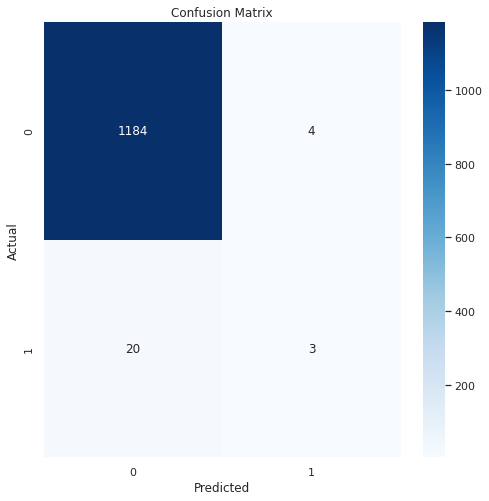

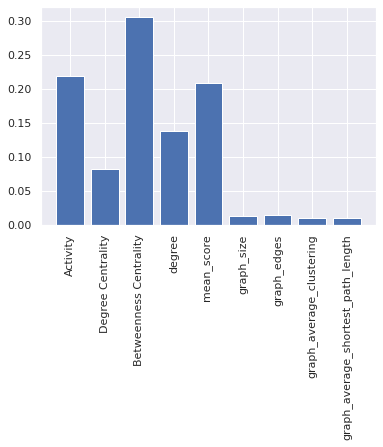

In [12]:
# random forrest test
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df_authors.head()

# remove columns
df_authors_model = df_authors.drop(columns=['sum_awards','sum_score','subreddit','author','type','mean_awards','sum_awards'])

# nan rows
df_authors_model = df_authors_model.dropna()

# split data into train and test sets
train, test = train_test_split(df_authors_model, test_size=0.2)

# split data into X and y
X_train = train.drop(columns=['award'])
y_train = train['award']
X_test = test.drop(columns=['award'])
y_test = test['award']

# create model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('RMSE: %f' % (rmse))
print('R2: %f' % (r2))

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# confusion matrix
cm = confusion_matrix(y_test, y_pred.round())
# plot
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()


# plot feature importance
importance = rf.feature_importances_
# plot feature importance
plt.bar([x for x in X_train.columns], importance)
plt.xticks(rotation=90)
plt.show()

## for post & comments


100%|██████████| 7/7 [02:44<00:00, 23.43s/it]


RMSE: 0.084586
R2: 0.000543


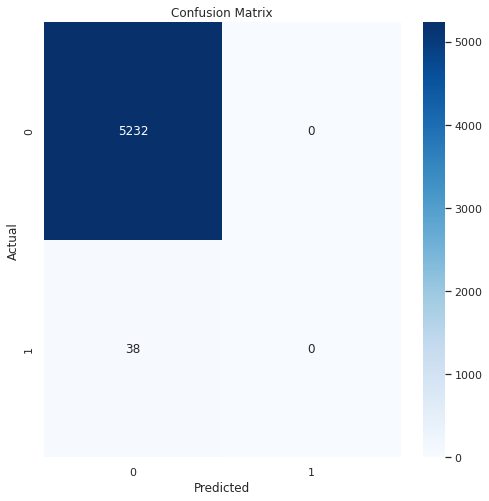

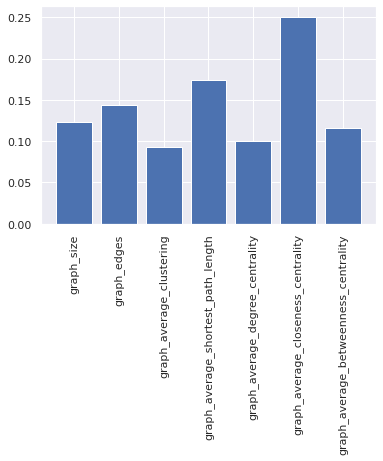

In [15]:
for subreddit in subreddits:
    df_comment_dict[subreddit]['subreddit'] = subreddit
    df_post_dict[subreddit]['subreddit'] = subreddit
# concat all comments in dict
com = pd.concat(df_comment_dict, ignore_index=True)[['award','id','subreddit','author','score']]
po = pd.concat(df_post_dict, ignore_index=True)[['award','id','subreddit','author','score']]

df_com_po = pd.concat([com,po], ignore_index=True)
df_com_po['score'] = df_com_po['score'].astype(int)
# df_com_po

for subreddit in tqdm.tqdm(subreddits):
    df_com_po.loc[df_com_po['subreddit']==subreddit,'graph_size'] = G_dict[subreddit].number_of_nodes()
    df_com_po.loc[df_com_po['subreddit']==subreddit,'graph_edges'] = G_dict[subreddit].number_of_edges()
    df_com_po.loc[df_com_po['subreddit']==subreddit,'graph_average_clustering'] = nx.average_clustering(G_dict[subreddit])
    df_com_po.loc[df_com_po['subreddit']==subreddit,'graph_average_shortest_path_length'] = nx.average_shortest_path_length(G_dict[subreddit])
    df_com_po.loc[df_com_po['subreddit']==subreddit,'graph_average_degree_centrality'] = np.mean([d for n, d in nx.degree_centrality(G_dict[subreddit]).items()])
    df_com_po.loc[df_com_po['subreddit']==subreddit,'graph_average_closeness_centrality'] = np.mean([d for n, d in nx.closeness_centrality(G_dict[subreddit]).items()])
    df_com_po.loc[df_com_po['subreddit']==subreddit,'graph_average_betweenness_centrality'] = np.mean([d for n, d in nx.betweenness_centrality(G_dict[subreddit]).items()])
    


# remove columns
df_com_po_model = df_com_po.drop(columns=['subreddit','author','id','score'])

# replace nan with zero
df_com_po_model = df_com_po_model.fillna(0)

# split data into train and test sets
train, test = train_test_split(df_com_po_model, test_size=0.2)

# split data into X and y
X_train = train.drop(columns=['award'])
y_train = train['award']
X_test = test.drop(columns=['award'])
y_test = test['award']

# create model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('RMSE: %f' % (rmse))
print('R2: %f' % (r2))

# confusion matrix
cm = confusion_matrix(y_test, y_pred.round())
# plot
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()


# plot feature importance
importance = rf.feature_importances_
# plot feature importance
plt.bar([x for x in X_train.columns], importance)
plt.xticks(rotation=90)
plt.show()

# WSB

In [38]:
import pandas as pd
from tqdm import tqdm
import praw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm
sns.set_theme()

In [15]:
sample = pd.read_csv('/home/pelle/Downloads/submissions_pmaw_2016-2021_wsb.csv',nrows=10)
dtypes = sample.dtypes # Get the dtypes
cols = sample.columns # Get the columns
dtype_dictionary = {} 
for c in cols:
    if str(dtypes[c]) == 'int64':
        dtype_dictionary[c] = 'float32' # Handle NANs in int columns
    else:
        dtype_dictionary[c] = str(dtypes[c])

df_posts = pd.read_csv('/home/pelle/Downloads/submissions_pmaw_2016-2021_wsb.csv',dtype=dtype_dictionary, 
                keep_default_na=False,
                na_values=['na',''],
                usecols=['author','created_utc','score','id'])
df_posts.created_utc = pd.to_datetime(df_posts.created_utc,unit='s')

In [5]:
# sample = pd.read_csv('/home/pelle/Downloads/comments_pmaw_2016-2021_wsb.csv',nrows=10)
# dtypes = sample.dtypes # Get the dtypes
# cols = sample.columns # Get the columns
# dtype_dictionary = {} 
# for c in cols:
#     if str(dtypes[c]) == 'int64':
#         dtype_dictionary[c] = 'float32' # Handle NANs in int columns
#     else:
#         dtype_dictionary[c] = str(dtypes[c])
# dtype_dictionary['author'] = 'str'
# dtype_dictionary['body'] = 'str'
# dtype_dictionary['parent_id'] = 'str'
# dtype_dictionary['link_id'] = 'str'
# dtype_dictionary['id'] = 'str'


# df_comments_chunked = pd.read_csv('/home/pelle/Downloads/comments_pmaw_2016-2021_wsb.csv', dtype=dtype_dictionary, 
#                  keep_default_na=False, 
#                 #  error_bad_lines=False,
#                  on_bad_lines='warn',
#                  na_values=['na',''],
#                  usecols=['author','id','created_utc','score'],chunksize=1000000)
# df_comments = pd.concat(df_comments_chunked, ignore_index=True)
# df_comments.created_utc = pd.to_datetime(df_comments.created_utc,unit='s')

In [4]:
# df_1RONYMAN=pd.concat([df_comments.loc[df_comments['author']=='1R0NYMAN'],df_posts.loc[df_posts['author']=='1R0NYMAN']])

In [86]:
# Read-only instance
def get_reddit_instance():
    reddit = praw.Reddit(client_id="OlWj7Mu4aXh0eg",
                                client_secret="fIzRhpEeBYAwi8_i2hcyzoWwDnWOag",
                                user_agent="Scrapper")
    return reddit

reddit = get_reddit_instance()

def get_n_awards(id):
    submission_awards = []
    submission = reddit.submission(id=id)
    submission_awards.append(submission.all_awardings)
    # get number of awards
    return [len(x) for x in submission_awards]

In [87]:
L=len(df_posts.loc[df_posts['author']=='1R0NYMAN'])
df_posts_10 = df_posts.groupby('author').filter(lambda x: len(x) == L)

In [89]:
authors = df_posts_10.author.unique()
# pick n random authors
n = 100
authors = np.random.choice(authors, n, replace=False)
authors = np.append(authors,'1R0NYMAN')

In [90]:
df_posts_10 = df_posts_10.loc[df_posts_10['author'].isin(authors)]
df_posts_10['award'] = df_posts_10['id'].apply(get_n_awards)
df_posts_10['award']=df_posts_10['award'].apply(lambda x: x[0])

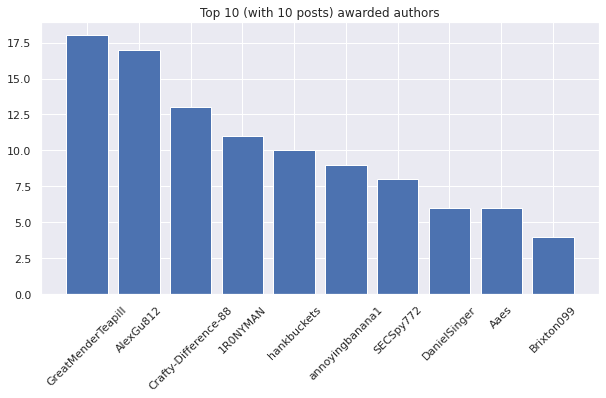

In [91]:
group=df_posts_10.groupby('author').sum().sort_values(by='award',ascending=False)

plt.figure(figsize=(10,5))
plt.bar(group.head(10).index, group.head(10)['award'], label='awards', align='center')
plt.xticks(rotation=45)
plt.title('Top 10 (with 10 posts) awarded authors')
plt.show()


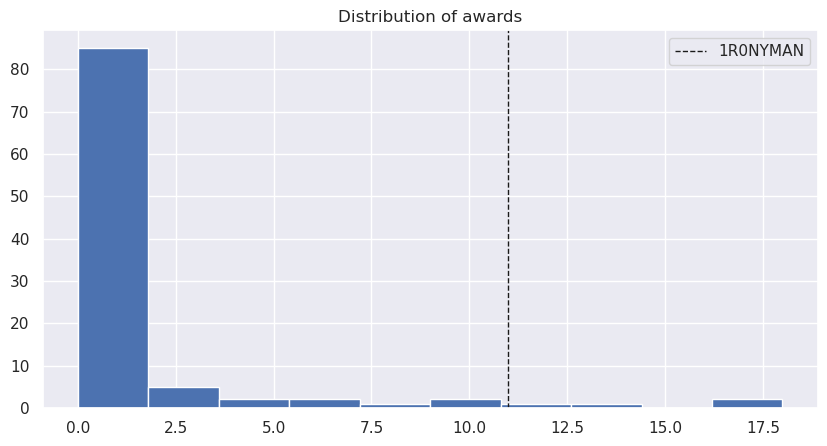

In [106]:
plt.figure(figsize=(10,5),dpi=100)
plt.hist(group['award'],align='mid')
plt.title('Distribution of awards')
plt.axvline(group.loc['1R0NYMAN']['award'], color='k', linestyle='dashed', linewidth=1, label='1R0NYMAN')
plt.legend()
plt.show()


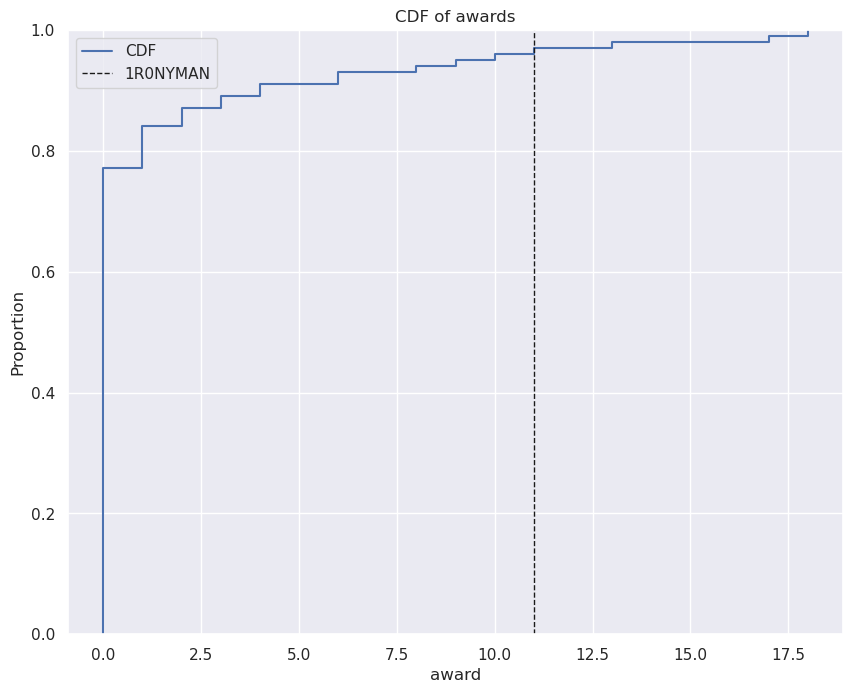

In [107]:
plt.figure(figsize=(10,8),dpi=100)
sns.ecdfplot(group['award'],stat='proportion',label='CDF')
plt.axvline(group.loc['1R0NYMAN']['award'], color='k', linestyle='dashed', linewidth=1,label='1R0NYMAN')
plt.title('CDF of awards')
plt.legend()
plt.show()

In [113]:
p = 1-norm.cdf(group.loc['1R0NYMAN']['award'], np.mean(group['award']), np.std(group['award']))
print('P-value: '+str(p.round(4)))

P-value: 0.0018


In [114]:
p_value = np.array(np.array(group['award']) > group.loc['1R0NYMAN']['award']).sum() / len(group['award'])
print('P-value: '+str(p_value.round(4)))

P-value: 0.0297
